# Shot Density

Previously in this series of tutorials, we walked through the creation of shot charts (check it out [here](https://github.com/basketballrelativity/basketball_data_science/blob/master/Chapter%202/Shot%20Charts.ipynb)). Shot charts work well on an individual level, but can get crowded when scaling to a team or season level. Using smoothing or binning techniques, shot charts can be converted to two-dimensional shot densities, making it easier to visually extract any patterns or tendencies. [Kirk Goldsberry](https://twitter.com/kirkgoldsberry?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor) popularized the visualization of shot location data in this manner, culminating in his book [Sprawlball: A Visual Tour of the New Era of the NBA](https://www.amazon.com/SprawlBall-Visual-Tour-New-Era/dp/1328767515).

This notebook walks through Section 3.5 of [Basketball Data Science with Applications in R](https://www.amazon.com/Basketball-Data-Science-Applications-Chapman-dp-1138600792/dp/1138600792/ref=mt_paperback?_encoding=UTF8&me=&qid=) (BDS) by exploring the `Player` class of the [py_ball](https://github.com/basketballrelativity/py_ball) package through use of the `shortchartdetail` endpoint of the [stats.nba.com](https://stats.nba.com) API to produce three types of shot density charts.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import seaborn as sns

from py_ball import player

HEADERS = {'Connection': 'keep-alive',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'x-nba-stats-origin': 'stats',
           'x-nba-stats-token': 'true',
           'Accept-Language': 'en-US,en;q=0.9',
           "X-NewRelic-ID": "VQECWF5UChAHUlNTBwgBVw==",
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6)' +\
                         ' AppleWebKit/537.36 (KHTML, like Gecko)' + \
                         ' Chrome/81.0.4044.129 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

## Data

The `shotchartdetail` endpoint accepts a variety of parameters, but only a few are relevant for shot-location purposes:
- `league_id`: '00' for the NBA
- `player_id`: The unique identifier for the player (0 returns shot data for the whole game)
- `game_id`: The unique identifier for the game of interest
- `season`: YYYY-ZZ season year format (This only affects the league averages returned)

In this notebook, we'll focus on [this game](https://stats.nba.com/game/0021800928/shotchart/) between the Hawks and Bulls on March 1, 2019. The URL contains the `game_id` we need.

In [2]:
league_id = '00' #NBA
player_id = '0' #All players
game_id = '0021800928'
season = '2018-19'

shots = player.Player(headers=HEADERS,
                      endpoint='shotchartdetail',
                      league_id=league_id,
                      player_id=player_id,
                      game_id=game_id,
                      season=season)
shot_df = pd.DataFrame(shots.data['Shot_Chart_Detail'])
shot_df.head(15)

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021800928,7,1628374,Lauri Markkanen,1610612741,Chicago Bulls,1,11,44,...,Right Side(R),8-16 ft.,10,103,27,1,0,20190301,ATL,CHI
1,Shot Chart Detail,0021800928,10,1628374,Lauri Markkanen,1610612741,Chicago Bulls,1,11,23,...,Center(C),24+ ft.,24,36,247,1,0,20190301,ATL,CHI
2,Shot Chart Detail,0021800928,12,1628989,Kevin Huerter,1610612737,Atlanta Hawks,1,11,13,...,Center(C),24+ ft.,25,41,247,1,0,20190301,ATL,CHI
3,Shot Chart Detail,0021800928,14,1627739,Kris Dunn,1610612741,Chicago Bulls,1,10,53,...,Center(C),Less Than 8 ft.,1,6,13,1,1,20190301,ATL,CHI
4,Shot Chart Detail,0021800928,15,1627752,Taurean Prince,1610612737,Atlanta Hawks,1,10,39,...,Left Side Center(LC),24+ ft.,25,-156,201,1,1,20190301,ATL,CHI
5,Shot Chart Detail,0021800928,17,201577,Robin Lopez,1610612741,Chicago Bulls,1,10,15,...,Center(C),Less Than 8 ft.,5,-13,55,1,0,20190301,ATL,CHI
6,Shot Chart Detail,0021800928,20,203897,Zach LaVine,1610612741,Chicago Bulls,1,9,53,...,Right Side Center(RC),24+ ft.,25,118,226,1,1,20190301,ATL,CHI
7,Shot Chart Detail,0021800928,23,203473,Dewayne Dedmon,1610612737,Atlanta Hawks,1,9,34,...,Center(C),24+ ft.,25,72,242,1,0,20190301,ATL,CHI
8,Shot Chart Detail,0021800928,25,203490,Otto Porter Jr.,1610612741,Chicago Bulls,1,9,21,...,Center(C),Less Than 8 ft.,1,4,11,1,0,20190301,ATL,CHI
9,Shot Chart Detail,0021800928,27,1627752,Taurean Prince,1610612737,Atlanta Hawks,1,9,11,...,Left Side(L),8-16 ft.,14,-147,11,1,1,20190301,ATL,CHI


For this tutorial, we'll focus just on the shot location fields:
- `LOC_X`: horizontal coordinate of a shot
- `LOC_Y`: vertical coordinate of a shot

## Drawing the Court

The coordinate system for the court has its origin at the basket. Positive horizontal locations are to the right side of the basket when facing it. Positive vertical locations are away from the basket when facing it. The unit of shot locations in `LOC_X` and `LOC_Y` are tenths of a foot. So, for example, a shot location of `(LOC_X, LOC_Y) = (0, 100)` is a distance of ten feet from the basket, directly in front of it.

Armed with this information and the [locations of NBA court markings](https://en.wikipedia.org/wiki/Basketball_court), we can create a function, `draw_court`, to abstract away visualizing an NBA court to use for creating shot charts. 

In [3]:
def draw_court(plot):
    """ draw_court draws an NBA halfcourt
    
    @param plot (seaborn.axisgrid.JointGrid): Figure
        object containing the plotted shot density
    Returns:
    
        fig (seaborn.axisgrid.JointGrid): Figure object visualizing
            an NBA court, overlayed with shot density
    """

    # These create the straight line portions of the court markings
    plot.ax_joint.plot([-250, 250], [-40, -40], 'k-') # endline
    plot.ax_joint.plot([-250, 250], [430, 430], 'k-') # halfcourt line
    plot.ax_joint.plot([-250, -250], [-40, 430], 'k-') # sideline
    plot.ax_joint.plot([250, 250], [-40, 430], 'k-') # sideline
    
    plot.ax_joint.plot([-30, 30], [-10, -10], 'k-') # backboard
    plot.ax_joint.plot([-60, -60], [-40, 150], 'k-') # lane
    plot.ax_joint.plot([60, 60], [-40, 150], 'k-') # lane
    plot.ax_joint.plot([-80, -80], [-40, 150], 'k-') # lane
    plot.ax_joint.plot([80, 80], [-40, 150], 'k-') # lane
    plot.ax_joint.plot([-80, 80], [150, 150], 'k-') # foul line

    plot.ax_joint.plot([220, 220], [-40, 90], 'k-') # 3pt straight
    plot.ax_joint.plot([-220, -220], [-40, 90], 'k-') # 3pt straight

    # These create the several circular portions of the court markings
    three_point = Arc((0, 0), width=237.5*2, height=237.5*2, theta1=22, theta2=158, linewidth=1.5)
    top_key = Arc((0, 150), width=60*2, height=60*2, theta1=0, theta2=180, linewidth=1.5)
    bottom_key = Arc((0, 150), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5, linestyle='--')
    basket = Arc((0, 0), width=7.5*2, height=7.5*2, theta1=0, theta2=360, linewidth=1.5)
    restricted = Arc((0, 7.5), width=40*2, height=40*2, theta1=0, theta2=180, linewidth=1.5)
    half_court = Arc((0, 430), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5)

    plot.ax_joint.add_patch(three_point)
    plot.ax_joint.add_patch(top_key)
    plot.ax_joint.add_patch(bottom_key)
    plot.ax_joint.add_patch(basket)
    plot.ax_joint.add_patch(restricted)
    plot.ax_joint.add_patch(half_court)

    # Adjusting figure properties
    plot.ax_joint.set_ylim(-50, 450)
    plot.ax_joint.set_aspect('equal')
    plot.fig.set_size_inches(10, 10)
    plot.ax_joint.set_xlabel('')
    plot.ax_joint.set_ylabel('')  
    plot.ax_joint.set(xticks=[])
    plot.ax_joint.set(yticks=[])
    plot.ax_joint.set_axis_off()

    return plot

## Plotting Shot Density

With the data and the `draw_court` function, we're equipped with everything we need to plot shot densities. To do this, the following leverages the [seaborn](https://seaborn.pydata.org/) Python package for data visualization. More specifically, we'll be focusing on the `JointPlot` objects in `seaborn` to produce estimates of bivariate distributions (examples shown [here](https://seaborn.pydata.org/tutorial/distributions.html)). `Seaborn` is great for data scientists, as it's built on top of `matplotlib` and interacts well with `pandas` objects.

The following `plot_shot_density` function ingests a DataFrame like `shot_df` and plots a shot density estimation for a player or team. The argument `plot_type` controls the type of shot density plotted and these include:
- `'hex'`: This plots the shot density as binned hexagrams, similar to Kirk Goldsberry's [recognizable shot density charts](https://twitter.com/kirkgoldsberry/status/1262190429040193539?s=20).
- `'kde'`: This plots the shot density as a [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation), similar to a heatmap. You can read more about kernel density estimation in seaborn [here](https://seaborn.pydata.org/generated/seaborn.kdeplot.html).
- `'contour'`: This plots the shot density as a 2D contour and also plots the locations of the individual shot attempts.

In [4]:
def plot_shot_density(shot_df, player_or_team, unit_id, plot_type='hex'):
    """ plot_shot_density plots a 2D shot density estimate given the
    shot DataFrame provided

    @param shot_df (DataFrame): DataFrame of shots with LOC_X and
        LOC_Y columns
    @param player_or_team (str): One of 'team' or 'player'
        strings indicating the type of shot chart to generate
    @param unit_id (int): Unique identifier of player or team
    @param plot_type (str): One of 'hex', 'kde', or 'contour',
        which controls the type of shot density visualization produced

    Returns

        plot (seaborn.axisgrid.JointGrid): Court visual with
            the shot density plotted plotted
    """

    # Initializing the court and subsetting the DataFrame
    # by provided player or team
    if player_or_team=='team':
        shot = shot_df[shot_df['TEAM_ID']==unit_id]
        plot_title = shot['TEAM_NAME'].iloc[0]
    else:
        shot = shot_df[shot_df['PLAYER_ID']==unit_id]
        plot_title = shot['PLAYER_NAME'].iloc[0]

    # Plot the type of 2D shot density estimation desired
    if plot_type == 'hex':
        plot = sns.jointplot(x=-shot['LOC_X'], y=shot['LOC_Y'], kind=plot_type, gridsize=20)
    elif plot_type == 'kde':
        plot = sns.jointplot(x=-shot['LOC_X'], y=shot['LOC_Y'], kind=plot_type)
    elif plot_type == 'contour':
        plot = (sns.jointplot(x=-shot['LOC_X'],
                              y=shot['LOC_Y'],
                              color='k',
                              alpha=0.25).plot_joint(sns.kdeplot, zorder=0, n_levels=6))
    else:
        print("Oops! You've provided an invalid plot_type value. Please use 'hex', 'kde', or 'contour'")
        return None

    # Draw NBA court markings and write title
    plot = draw_court(plot)
    plot.ax_joint.set_title(plot_title + ' Shot Density', fontsize=14)
    plt.show()
    plt.close()

    return plot

## Results

I strategically chose a game that went into four (4!) overtime periods, so there will be plenty of shots available to produce shot densities.

### Hexagram Shot Densities

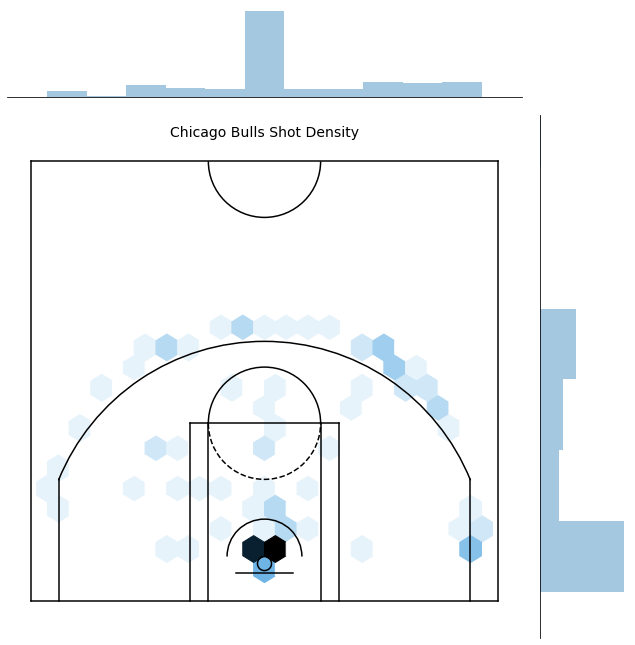

In [5]:
fig = plot_shot_density(shot_df, 'team', 1610612741, 'hex')

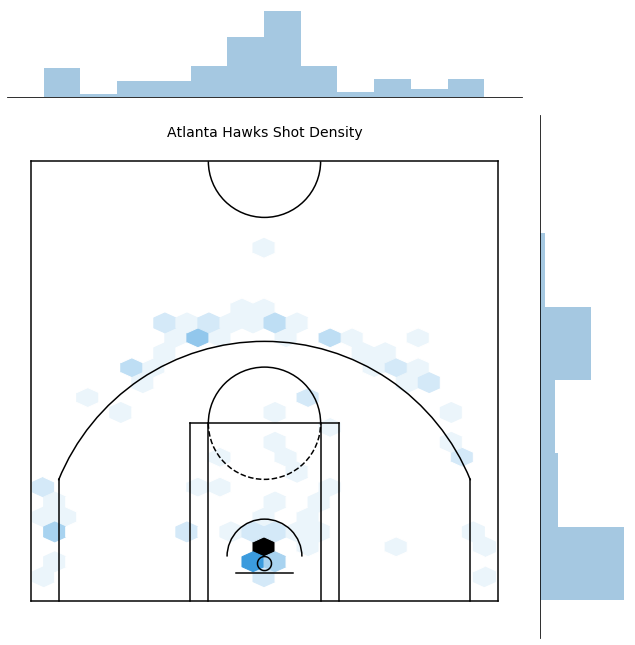

In [6]:
fig = plot_shot_density(shot_df, 'team', 1610612737, 'hex')

The hexagram shot densities look pretty similar for both the Bulls and the Hawks. The only discernable difference seems to be that the Bulls venture more into the midrange (especially outside of the paint) when compared to the Hawks.

### Kernel Density Estimation Shot Densities

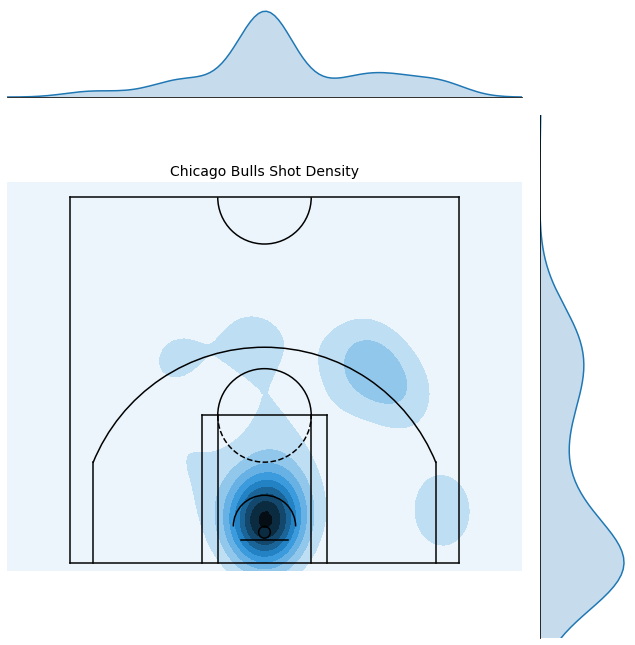

In [7]:
fig = plot_shot_density(shot_df, 'team', 1610612741, 'kde')

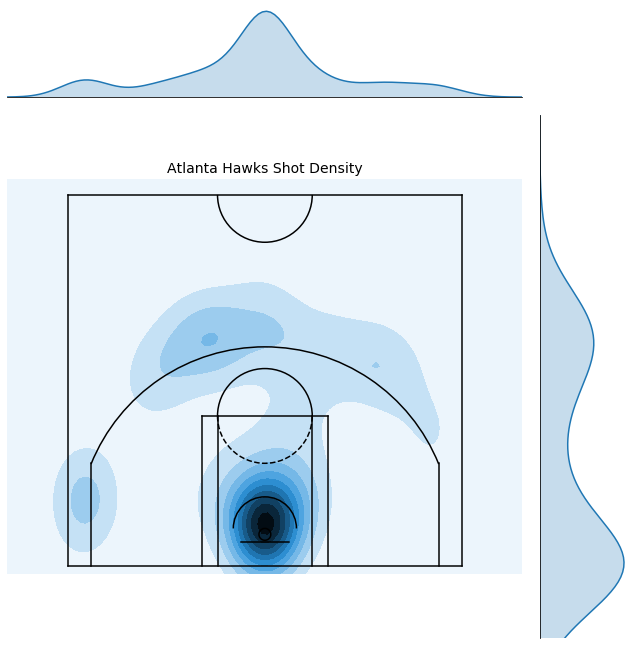

In [8]:
fig = plot_shot_density(shot_df, 'team', 1610612737, 'kde')

The kernel density estimations abstract some detail away, but some patterns are easier to discern from these visualizations. For example, the Bulls tended to favor three-point field goal attempts from the left wing and left corner, while the Hawks favored above-the-break and right corner three-point field goal attempts.

### Contour Shot Densities

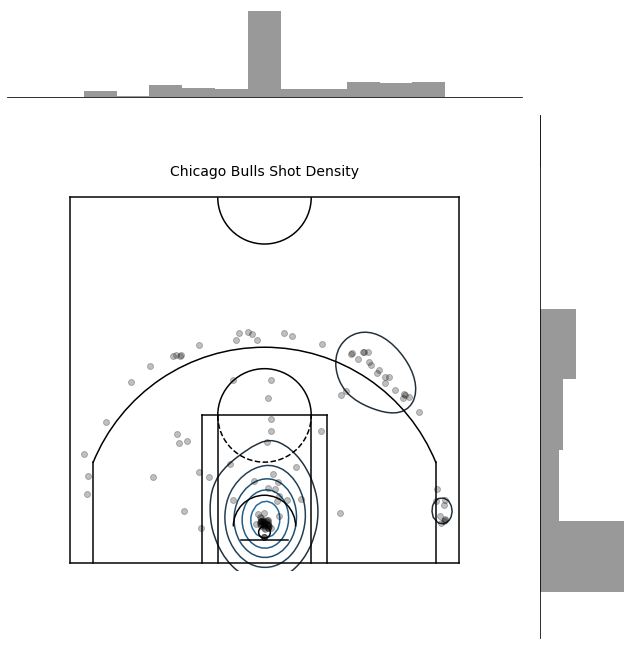

In [9]:
fig = plot_shot_density(shot_df, 'team', 1610612741, 'contour')

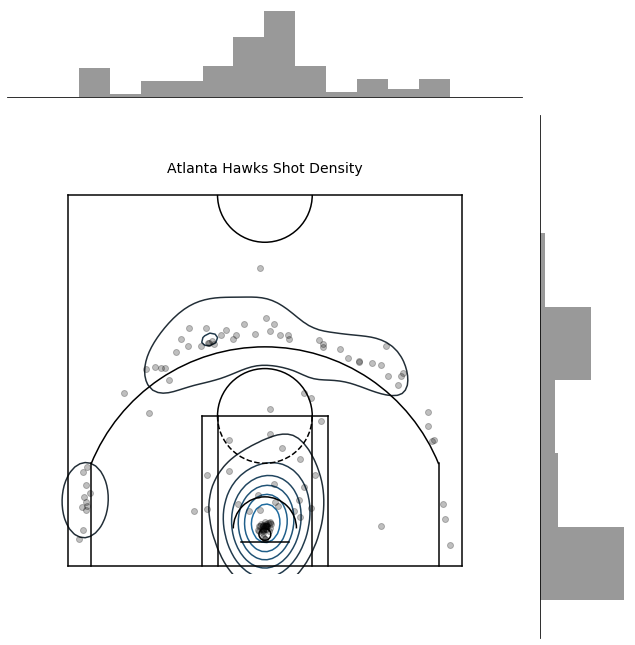

In [10]:
fig = plot_shot_density(shot_df, 'team', 1610612737, 'contour')

The contour plots seem to be a happy medium between the hexagram and kernel density estimation shot densities. The contours show general shooting trends, while the scatter plot of individual shots provide more granularity.

## Season-Level Shot Densities

While game-level shot densities are interesting, season-level shot densities provide information related to the general offensive philosophy of a team or the offensive style of a player. I pulled shot location data for the 2018-19 NBA regular season to allow for the production of season-level shot densities, so let's check out a few!

In [11]:
shot_df = pd.read_csv('shotchart_2018.csv')

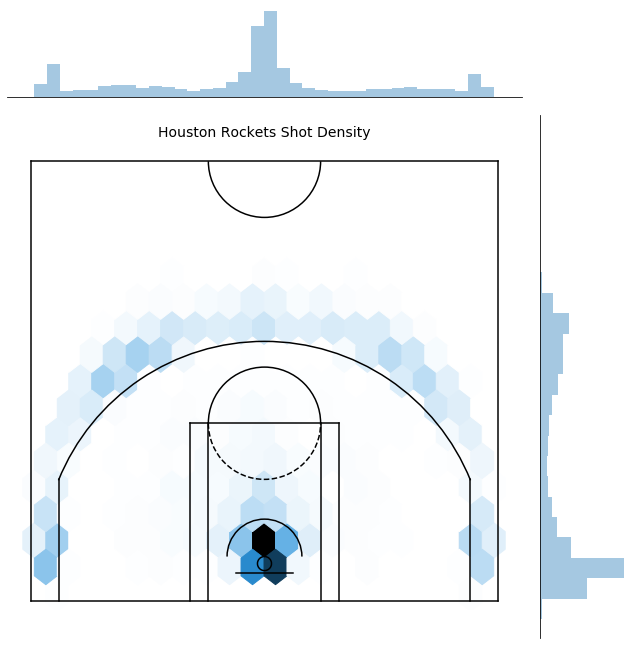

In [12]:
fig = plot_shot_density(shot_df, 'team', 1610612745, 'hex') # Houston Rockets

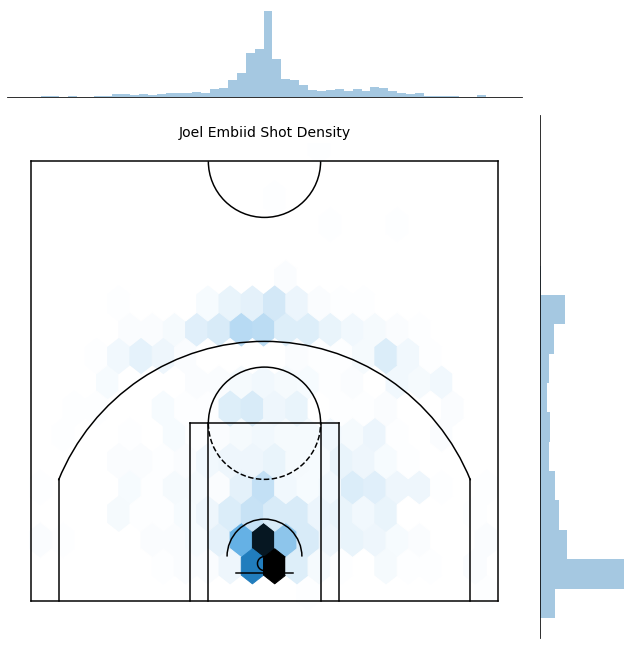

In [15]:
fig = plot_shot_density(shot_df, 'player', 203954, 'hex') # Joel Embiid

The Houston Rockets shot density appears exactly as you would expect! A heavy majority of their shots take place from beyond the arc or in the immediate vicinity of the basket. Joel Embiid's shot density covers the middle of the court, with his long-range game favoring above-the-break threes and showing a bit of a propensity for the midrange.

## Conclusion

This notebook provides the foundation to produce shot densities for NBA players and teams. Visualizing shots in this manner can give insight into the style or strategy of a team or player on the offensive end. Section 3.5 of [BDS](https://www.amazon.com/Basketball-Data-Science-Applications-Chapman-dp-1138600792/dp/1138600792/ref=mt_paperback?_encoding=UTF8&me=&qid=) details how to produce these visualizations in R.

Try playing around with these visualizations to enhance them or add additional context!